# A common mistake to avoid when encoding ordinal features

Notebook version of the blog post [A common mistake to avoid when encoding ordinal features](https://towardsdatascience.com/numpy-indexing-explained-c376abb2440d)

In [2]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from pylab import rcParams

Ordinal features are a very common type of categorical data in which its different categories present a natural order. An example could be a feature indicating the temperature taking the categories cool, mild and hot. 
A common issue in these cases is choosing an appropriate way to encode these features. This is a very important aspect to take into account, which will determine the value that the feature will be adding to a model.

A fairly common mistake, is to just assign a unique numerical value to each category of a feature, disregarding any order it may have. The motivation behind this post really comes from answering this question in stack overflow where, since I gave quite a detailed explanation of the issue, I thought it would be also worth writing a post about it here. The idea in this post is to explore and understand why this is not a good idea, and which other approaches we should be using instead.


Mapping the inherent ordinality of a feature to a wrong scale will have a very negative impact on the performance of the model (that is, proportional to the relevance of the feature).

As mentioned, ordinal features have a natural ordering, or to put it another way, they have an ordinal scale with a **ranking**. So if we want to preserve the features' value after encoding it, we want to make sure that it resembles their ranking.

An intuitive way to think about it, is by the way a decision tree sets its boundaries. During training, a decision tree will learn the optimal features to set at each node, as well as an optimal threshold whereby unseen samples will follow a branch or another depending on these values.

If we encode an ordinal feature using a simple `LabelEncoder` for instance, that could lead to a feature having say 1 representing warm, 2 which maybe would translate to hot, and a 0 which may translate to boiling. In such case, instead of having a higher degree of certainty in which path a sample should take due to a higher value, the optimal threshold just ends up being meaningless, and we lose its predictable power.

----

Though seeing why this is so will be more intuitive than just words (decision trees to the rescue :). Let's use the good ol' Play Tennis example:

In [46]:
df = pd.DataFrame(
        {'Hours of dedication': pd.Categorical(
              values =  ['20-25', '20-25', '5-10', '5-10', '40-45', 
                         '0-5', '15-20', '20-25', '30-35', '5-10',
                         '10-15', '45-50', '20-25', '40-45', '30-35'],
              categories=['0-5', '5-10', '10-15', '15-20', 
                          '20-25', '25-30','30-35','40-45', '45-50']),

         'Assignments avg grade': pd.Categorical(
             values =  ['B', 'C', 'F', 'C', 'B', 
                        'D', 'C', 'A', 'B', 'B', 
                        'D', 'A', 'D', 'D', 'C'],
             categories=['F', 'D', 'C', 'B','A']),

         'Result': pd.Categorical(
             values = ['Pass', 'Pass', 'Fail', 'Fail', 'Pass', 
                       'Fail', 'Fail','Pass','Pass', 'Fail', 
                       'Fail', 'Pass', 'Pass', 'Pass', 'Pass'], 
             categories=['Fail', 'Pass'])
        }
    )

I've defined all columns as `pd.Categorical`, having all categories start from the most *negative* value (that is, those that push the prediction towards No).

The advantage of defining a categorical column as a pandas' categorical, is that we get to establish an *order* among its categories. This allows for much faster sorting based on the established order rather than lexical sorting. And it can also be used as a simple way to get codes for the different categories according to their order.

So the dataframe we'll be using looks as follows:

In [4]:
df

,Hours of dedication,Assignments avg grade,Result
0,20-25,B,Pass
1,20-25,C,Pass
2,5-10,F,Fail
3,5-10,C,Fail
4,40-45,B,Pass
5,0-5,D,Fail
6,15-20,C,Fail
7,20-25,A,Pass
8,30-35,B,Pass
9,5-10,B,Fail


And as mentioned, we can obtain the assigned codes to each category in each categorical column through the `pd.Series.cat.codes method`:

In [18]:
X = df.apply(lambda x: x.cat.codes)
X.head(10)

,Hours of dedication,Assignments avg grade,Result
0,4,3,1
1,4,2,1
2,1,0,0
3,1,2,0
4,7,3,1
5,0,1,0
6,3,2,0
7,4,4,1
8,6,3,1
9,1,3,0


Now let's fit a `DecisionTreeClassifier`, and see how the tree has defined the splits:

In [19]:
dt = tree.DecisionTreeClassifier()
X = X.drop(['Result'],1)
y = df.Result
dt.fit(X_right, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The `sklearn.tree` module provides a function to plot a fitted decision tree. Let's use it to see what the decision tree looks like:

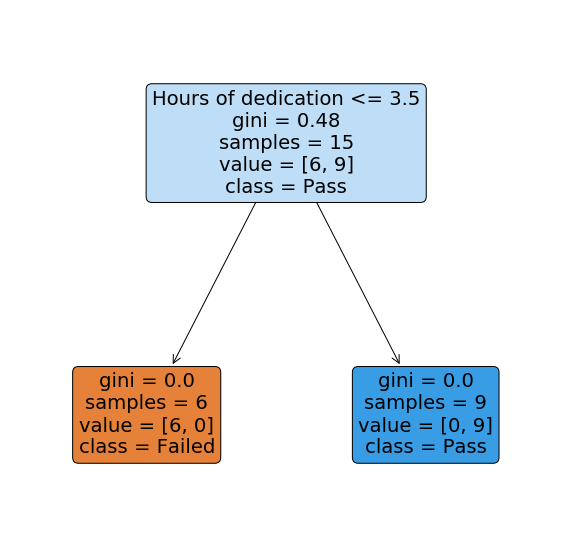

In [51]:
rcParams['figure.figsize'] = 10, 10
g = tree.plot_tree(dt, 
                   feature_names = X.columns,
                   class_names=['Failed', "Pass"],
                   filled = True,
                   label='all',
                   rounded=True)

Is that all?? Well… yes! I've actually set the features in such a way that there is this simple and obvious relation between the Hours of dedication feature, and whether the exam is passed or not, which makes it seem clear that the problem should be very easy to model.

----

Now let's try to do the same by directly encoding all features with an output we could obtain through a `LabelEncoder`, so disregarding the actual ordinality of the features, and just assigning a value based on the position in which they occur:

In [16]:
df_wrong = pd.DataFrame(
        {'Hours of dedication': pd.Categorical(
                  values =  ['25-30', '20-25', '5-10', '5-10', '40-45', 
                             '0-5', '15-20', '20-25', '30-35', '5-10',
                             '10-15', '45-50', '20-25'],
                  categories=['0-5','40-45', '25-30', '10-15', '5-10',
                              '45-50','15-20', '20-25','30-35']),

         'Assignments avg grade': pd.Categorical(
                 values =  ['B', 'C', 'F', 'C', 'B', 
                            'D', 'C', 'A', 'B', 'B', 
                            'B', 'A', 'D'],
                 categories=['A', 'C', 'F', 'D', 'B',]),

         'Result': pd.Categorical(
                 values = ['Pass', 'Pass', 'Fail', 'Fail', 'Pass', 
                           'Fail', 'Fail','Pass','Pass', 'Fail', 
                           'Fail', 'Pass', 'Pass'], 
                 categories=['Fail', 'Pass'])
        }
    )

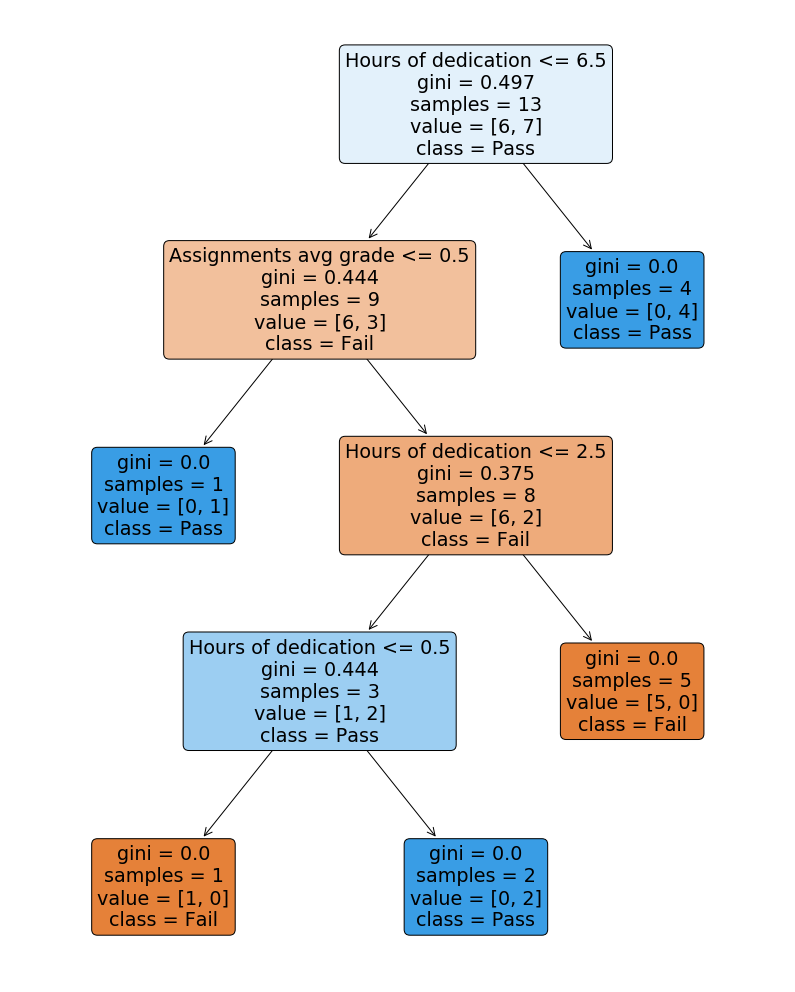

In [50]:
rcParams['figure.figsize'] = 14,18
X_wrong = df_wrong.drop(['Result'],1).apply(lambda x: x.cat.codes)
y = df_wrong.Result

dt_wrong = tree.DecisionTreeClassifier()
dt_wrong.fit(X_wrong, y)

t = tree.plot_tree(dt_wrong, 
                   feature_names = X_wrong.columns,
                   class_names=["Fail", "Pass"],
                   filled = True,
                   label='all',
                   rounded=True)

As expected the tree structure is way more complex than necessary for the simple problem we're trying to model. In order for the tree to correctly predict all training samples the tree has expanded until a depth of `4`, when a single node should be necessary.

In [34]:
dt_wrong.get_depth()

4

So to summarise, preserving the ordinality of the features once encoding them is crucial, otherwise as made clear with this example we'll lose all their predictable power and just add *noise* to our model.

-----

## How should Ordinal Features be encoded?

In the example above, we've seen a simple way to encode ordinal features using `pd.Categorical`. But what we'll be interested in most of the times is not only to transform a given set of features, but also to replicate the applied transformations on unseen data.

For that we have the `OrdinalEncoder` from [Category Encoders](https://contrib.scikit-learn.org/categorical-encoding/). This class enables us to:

* Define a dictionary mapping categories to codes
* *Fit* the encoder with the mapping dictionary and *transform* on unseen data

Let's see how to use it with an example with several features. The `OrdinalEncoder` receives a mapping parameter expecting a list of dictionaries, each of which containing the keys `col` and `mapping`:

In [36]:
df = pd.DataFrame(
        {'Outlook': pd.Categorical(
                  values =  ['Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 
                             'Rainy', 'Overcast', 'Sunny', 'Sunny', 'Rainy', 
                             'Sunny', 'Overcast', 'Overcast', 'Rainy'],
                  categories=['Rainy', 'Overcast', 'Sunny']),
         
         'Temperature': pd.Categorical(
                 values =  ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 
                            'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 
                            'Mild', 'Mild', 'Hot', 'Mild'],
                 categories=['Cool', 'Mild', 'Hot']),
         
         'Humidity': pd.Categorical(
                 values = ['High', 'High', 'High', 'High', 'Normal',
                           'Normal', 'Normal', 'High', 'Normal', 'Normal', 
                           'Normal', 'High', 'Normal', 'High'],
                 categories=['Normal', 'High']),
         
         'Windy': pd.Categorical(
                 values = ['False', 'True', 'False', 'False', 'False',
                           'True', 'True', 'False', 'False', 'False', 
                           'True', 'True', 'False', 'True'],
                 categories=['False', 'True']),
         
         'PlayTennis': pd.Categorical(
                 values = ['No', 'No', 'Yes', 'Yes', 'Yes', 
                           'No', 'Yes','No','Yes', 'Yes', 
                           'Yes', 'Yes', 'Yes','No'],
                 categories=['No', 'Yes'])
        })

In [41]:
ordinal_cols_mapping = [{
    "col": "Outlook",
    "mapping": {
        'Rainy': 0,
        'Overcast': 1,
        'Sunny': 2
    }}, {
    "col": "Temperature",
    "mapping": {
        'Cool': 0,
        'Mild': 1,
        'Hot': 2,
    }}, {        
    "col": "Humidity",
    "mapping": {
        'Normal': 0,
        'High': 1
    }}, {
    "col": "Windy",
    "mapping": {
        'False': 0,
        'True': 1,
    }}, {
    "col": "PlayTennis",
    "mapping": {
        'No': 0,
        'Yes': 1,
    }}
]

Then we can create a new instance of the encoder with:

In [42]:
df

,Outlook,Temperature,Humidity,Windy,PlayTennis
0,Sunny,Hot,High,False,No
1,Sunny,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Rainy,Mild,High,False,Yes
4,Rainy,Cool,Normal,False,Yes
5,Rainy,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Sunny,Mild,High,False,No
8,Sunny,Cool,Normal,False,Yes
9,Rainy,Mild,Normal,False,Yes


In [43]:
encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, 
                         return_df = True)  

So by transforming on the same dataframe as above, we get:

In [40]:
df_train = encoder.fit_transform(df)
df_train

,Outlook,Temperature,Humidity,Windy,PlayTennis
0,0,2,1,0,0
1,0,2,1,1,0
2,1,2,1,0,1
3,2,1,1,0,1
4,2,0,0,0,1
5,2,0,0,1,0
6,1,0,0,1,1
7,0,1,1,0,0
8,0,0,0,0,1
9,2,1,0,0,1


----

So to summarise, preserving the ordinality of the features once encoding them is crucial, otherwise as made clear with this example we'll lose all their predictable power and just add noise to our model.